In [ ]:
#Install any packages you need
! pip install pandas
! pip install matplotlib
! pip install scipy
! pip install numpy

In [127]:
import pandas as pd

data = pd.read_csv("Data.csv")
#These are the values most likely to change
xField = "Year"
yField = "Europe"

data = data.dropna(subset=[yField])
for i in data.columns:
    data[i] = pd.to_numeric(data[i], errors="coerce")

data = data.dropna(subset=[yField])
data.head()

,Year,United States,Europe,France,China,India,Japan
0,2006,NaN,98.0,NaN,NaN,NaN,NaN
1,2007,NaN,173.0,NaN,NaN,NaN,NaN
2,2008,NaN,279.0,15.0,NaN,NaN,NaN
3,2009,NaN,422.0,24.0,NaN,NaN,NaN
4,2010,NaN,588.0,38.0,NaN,NaN,NaN


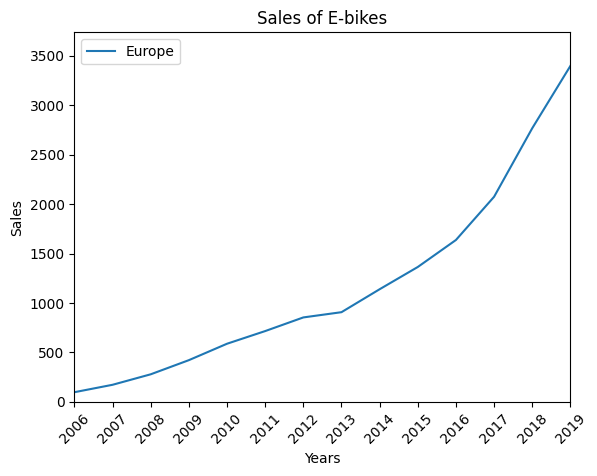

In [128]:
from matplotlib import pyplot as plt

def plotting(x, y):
    #These are the values most likely to change
    plt.title("Sales of E-bikes")
    plt.xlabel("Years")
    plt.ylabel("Sales")

    plt.xlim(x.iloc[0], x.iloc[-1])
    plt.ylim(0, max(y) * 1.1)
    plt.xticks(x[::1], rotation=45, fontsize=10)

    plt.legend(loc="upper left")

plt.plot(data[xField], data[yField], label=yField)
plotting(data[xField], data[yField])

In [157]:
trainingData = data.iloc[0::]
testingingData = data.iloc[0::]

trainingData.head(), testingingData.head()

(   Year  United States  Europe  France  China  India  Japan
 0  2006            NaN    98.0     NaN    NaN    NaN    NaN
 1  2007            NaN   173.0     NaN    NaN    NaN    NaN
 2  2008            NaN   279.0    15.0    NaN    NaN    NaN
 3  2009            NaN   422.0    24.0    NaN    NaN    NaN
 4  2010            NaN   588.0    38.0    NaN    NaN    NaN,
    Year  United States  Europe  France  China  India  Japan
 0  2006            NaN    98.0     NaN    NaN    NaN    NaN
 1  2007            NaN   173.0     NaN    NaN    NaN    NaN
 2  2008            NaN   279.0    15.0    NaN    NaN    NaN
 3  2009            NaN   422.0    24.0    NaN    NaN    NaN
 4  2010            NaN   588.0    38.0    NaN    NaN    NaN)

In [208]:
import scipy.optimize as opt
import numpy as np

#Change code if we know total population

def bassDiffusion(t, p, q, m):
    a = 1 - np.exp(-(p+q)*t)
    b = 1 + (q/p) * np.exp(-(p+q)*t)
    return a/b * m

values, errors = opt.curve_fit(bassDiffusion, np.arange(len(trainingData[xField])), trainingData[yField], p0=[0.001, 0.001, 100], maxfev=10000000)
values

array([1.97615266e-07, 1.66778463e-01, 3.56715402e+08])

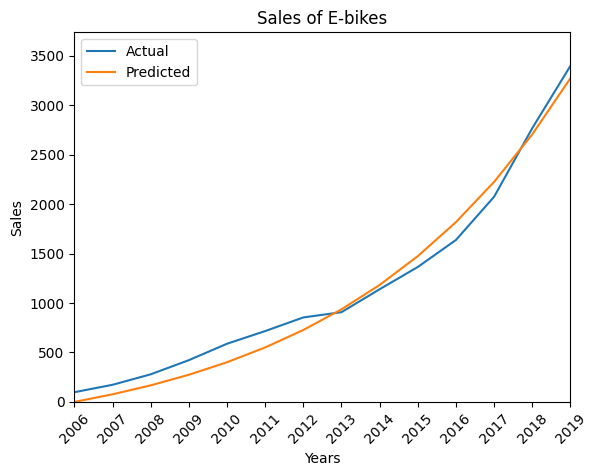

In [205]:
plt.plot(testingingData[xField], testingingData[yField], label="Actual")

testingPrediction = bassDiffusion(np.arange(len(testingingData[xField])), *values)
plt.plot(testingingData[xField], testingPrediction, label="Predicted")

plotting(testingingData[xField], testingingData[yField])

In [206]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(testingPrediction, testingingData[yField]))
mean = testingingData[yField].mean()
print(f"Mean: {mean}, RMSE: {rmse}, Score: {1 - rmse / mean}")

Mean: 1172.5, RMSE: 125.63982730426959, Score: 0.89284449696864


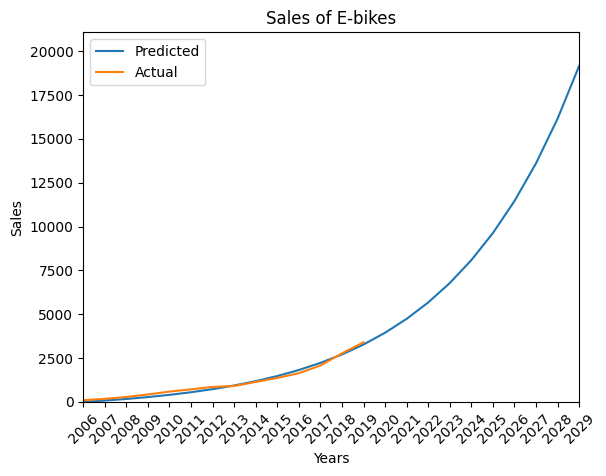

In [207]:
prediectedAmount = 10
predictionValues = bassDiffusion(np.arange(len(testingingData[xField]) + prediectedAmount), *values)
dateRange = np.arange(min(testingingData[xField]), max(testingingData[xField]) + prediectedAmount + 1)

prediction = pd.DataFrame({xField: dateRange, yField: predictionValues})

plt.plot(prediction[xField], prediction[yField], label="Predicted")
plt.plot(data[xField], data[yField], label="Actual")
plotting(prediction[xField], prediction[yField])